In [36]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
import seaborn as sn
import math
from sys import stdout


In [2]:

class FuzzyCMeans:
    def __init__(self, c=4, m=2, threshold=0.0000000000001):
        self.c = c
        self.m = m
        self.threshold = threshold

    def get_initial_membership_matrix(self):    
        self.membership_matrix = np.random.randint(low=100, high=200, size=(self.data.shape[0], self.c))
        self.membership_matrix = self.membership_matrix/self.membership_matrix.sum(axis=1, keepdims=True)
        self.centroids = np.random.randint(low=-4, high=4, size=(self.c, self.data.shape[1]))
        membership_matrix_powered = np.power(self.membership_matrix, self.m)
        return membership_matrix_powered
    
    def get_new_centroid(self,membership_matrix_powered):
        membership_matrix_powered = np.power(self.membership_matrix, self.m)
        membership_matrix_powered = membership_matrix_powered/membership_matrix_powered.sum(axis=0, keepdims=True)
        new_centroids = np.matmul(membership_matrix_powered.T, self.data)
        return new_centroids
    
    
    def get_cluster(self):
        clusters = {}
        clusters_ind = {}
        for i in range(self.c):
            clusters[i] = []
            clusters_ind[i] = []        
        for i, cluster_id in enumerate(self.max_membership_indices):
            clusters[cluster_id].append(self.data[i])
            clusters_ind[cluster_id].append(i)
        return clusters,clusters_ind
    
    def get_new_membership_matrix(self,new_centroids):
        new_membership_matrix = np.zeros(shape=(self.data.shape[0], self.c))
        for i in range(new_membership_matrix.shape[0]):
            for j in range(new_membership_matrix.shape[1]):
                new_membership_matrix[i][j] = 1./np.linalg.norm(self.data[i]-new_centroids[j])
        new_membership_matrix = np.power(new_membership_matrix, 2./(self.m-1))
        new_membership_matrix = new_membership_matrix/new_membership_matrix.sum(axis=1, keepdims=True)   
        return new_membership_matrix

    def get_new_sse_error(self,new_membership_matrix_powered,new_centroids):
        new_sse_error= 0
        for j in range(self.c):
            for i in range(self.data.shape[0]):
                new_sse_error += new_membership_matrix_powered[i][j] * np.power(np.linalg.norm(self.data[i]-new_centroids[j]), 2)
        return new_sse_error
        
    def fit(self, X):
        self.data = X
        membership_matrix_powered = self.get_initial_membership_matrix()
        self.sse_error = 0.
        for j in range(self.c):
            for i in range(self.data.shape[0]):
                self.sse_error += membership_matrix_powered[i][j] * np.power(np.linalg.norm(self.data[i]-self.centroids[j]), 2)
        iteration_count = 1
        while True:
            iteration_count = iteration_count + 1
            new_centroids = self.get_new_centroid(membership_matrix_powered)
            new_membership_matrix = self.get_new_membership_matrix(new_centroids)
            new_membership_matrix_powered = np.power(new_membership_matrix, self.m)
            new_sse_error = self.get_new_sse_error(new_membership_matrix_powered,new_centroids)            
            if (self.sse_error - new_sse_error) < self.threshold:
                break
            self.centroids = new_centroids.copy()
            self.membership_matrix = new_membership_matrix.copy()
            self.sse_error = new_sse_error
            self.max_membership_indices = np.argmax(self.membership_matrix, axis=1)
            

In [30]:
def get_label(cluster):
    Y_label = [Y[i] for i in cluster]
    data = collections.Counter(Y_label)
    return data.most_common(1)[0][0]


def predict(cluster,k):
    Y_predict = ['' for i in range(len(Y))]
    for i in range(k):
        label = get_label(cluster[i])
        for ind in cluster[i]:
            Y_predict[ind] = label
    return Y_predict

def one_hot_encode(Y_):
    Y_encoded  = [None for i in range(len(Y_))]
    unique = { val:i for i,val in enumerate(np.unique(Y_))} 
    runique = { i:val for i,val in enumerate(np.unique(Y_))} 
    for i in range(len(Y_)):
        Y_encoded[i] = unique[Y_[i]]
    return Y_encoded,runique

def compute_confusion_matrix(true, pred):
    K = len(np.unique(true))
    true,label_true = one_hot_encode(true)
    pred,label_pred = one_hot_encode(pred)
    result = np.zeros((K, K))
    for i in range(len(true)):
        result[true[i]][pred[i]] += 1
    return result,label_true

def classification_report(cm):
    true_pos = cm[0][0]
    true_neg = cm[1][1]
    false_pos = cm[1][0]
    false_neg = cm[0][1]
    print("True Positive : ",true_pos)
    print("True Negative : ",true_neg)
    print("False Positive : ",false_pos)
    print("False Negative : ",false_neg)
    print("Hit Ratio : ",true_pos/(true_pos+false_neg))
    print("False Alarm rate : ",false_pos/(false_pos+true_neg))
    accuracy = 0
    total = np.sum(cm)
    diagonal = np.sum(np.diag(cm))
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    recall_ = true_pos/(true_pos+false_neg)
    precision_ = true_pos/(false_pos+true_pos)
    print("Recall : =>  ",recall_)
    print("Precision : =>  ",precision_)
    f1_score = (2*precision_*recall_)/(precision_+recall_)
    print("F1-score : => ",f1_score)
    print("Accuracy : => ",(diagonal/total)*100)
    
    
def classification_report2(cm,label):
    print("\n")
    accuracy = 0
    total = np.sum(cm)
    diagonal = np.sum(np.diag(cm))
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    for i in range(len(precision)):
        print("Precision ("+label[i]+") :: ===>", precision[i])
        print("Recall  ("+label[i]+")   :: ===>", recall[i])
        print("\n")
    recall_ = np.mean(recall)
    precision_ = np.mean(precision)
    print("Recall(avg) OR hit ratio(avg):: ====>  ",recall_)
    print("Precision(avg)               :: ====>  ",precision_)
    f1_score = (2*precision_*recall_)/(precision_+recall_)
    print("F1-score                     :: ====> ",f1_score)
    print("Accuracy                     :: ====> ",(diagonal/total)*100)

In [4]:
data = pd.read_csv('iris.data',header=None)
X_array = data.to_numpy()
X_ = X_array[:,:-1]
Y = X_array[:,-1]
X = np.array(X_, dtype = np.float)
data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
c_mean = FuzzyCMeans(3,2,0.0001)
c_mean.fit(X)
clusters,cluster_ind = c_mean.get_cluster()

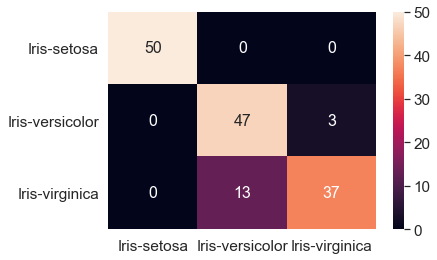



Precision (Iris-setosa) :: ===> 1.0
Recall  (Iris-setosa)   :: ===> 1.0


Precision (Iris-versicolor) :: ===> 0.7833333333333333
Recall  (Iris-versicolor)   :: ===> 0.94


Precision (Iris-virginica) :: ===> 0.925
Recall  (Iris-virginica)   :: ===> 0.74


Recall(avg) OR hit ratio(avg):: ====>   0.8933333333333332
Precision(avg)               :: ====>   0.9027777777777777
F1-score                     :: ====>  0.8980307248169913
Accuracy                     :: ====>  89.33333333333333


In [6]:
Y_pred = predict(cluster_ind,c_mean.c)
cm,label = compute_confusion_matrix(Y,Y_pred)
list_ = label.values()
df_cm = pd.DataFrame(cm,list_,list_)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
classification_report2(cm,label)

In [31]:
data = None
X_array = None
X_ =None
Y = None
X = None
data = pd.read_csv('SPECTF_test.csv')
X_array = data.to_numpy()
X_ = X_array[:,:-1]
Y = X_array[:,-1]
X = np.array(X_, dtype=np.float)
data.head()

,Attr_1,Attr_2,Attr_3,Attr_4,Attr_5,Attr_6,Attr_7,Attr_8,Attr_9,Attr_10,...,Attr_36,Attr_37,Attr_38,Attr_39,Attr_40,Attr_41,Attr_42,Attr_43,Attr_44,Class
0,32,41,76,34,65,53,30,54,16,51,...,43,67,61,29,31,17,8,18,11,Yes
1,76,65,60,40,32,34,65,50,53,37,...,51,65,59,43,39,35,30,24,21,Yes
2,60,51,75,60,65,45,64,55,55,61,...,68,69,63,62,53,57,31,46,30,Yes
3,64,60,71,69,71,65,66,64,68,59,...,55,66,58,65,65,75,64,61,56,Yes
4,65,69,66,76,58,67,65,72,66,64,...,64,71,70,72,69,70,65,63,61,Yes


In [32]:
c_mean = FuzzyCMeans(2,2,0.0001)
c_mean.fit(X)
clusters,cluster_ind = c_mean.get_cluster()

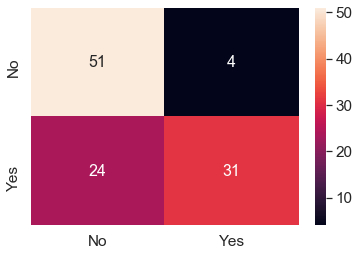

True Positive :  51.0
True Negative :  31.0
False Positive :  24.0
False Negative :  4.0
Hit Ratio :  0.9272727272727272
False Alarm rate :  0.43636363636363634
Recall : =>   0.9272727272727272
Precision : =>   0.68
F1-score : =>  0.7846153846153845
Accuracy : =>  74.54545454545455


In [33]:
Y_pred = predict(cluster_ind,c_mean.c)
cm,label = compute_confusion_matrix(Y,Y_pred)
list_ = label.values()
df_cm = pd.DataFrame(cm,list_,list_)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
classification_report(cm)